# Лабораторная работа №5.  Нейросети
##  Распознавание лиц с помощью нейросети

Для начала обновим библиотеку для работы с изображениями до той версии, на которой работает то, что нам нужно, хотя и на 8.0.1 все ок.

In [ ]:
!pip install --upgrade Pillow==6.1.0

In [ ]:
!pip install mtcnn
!pip install keras --upgrade

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12921495206130625907
]


 ### С нашей задачей хорошо справляется архитектура VGGFace. Реализуем ее в классах keras.

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation, Dense
from tensorflow.python.client import device_lib



from mtcnn import MTCNN
import cv2

model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))

### Перед тем, как распознавать лицо, нам необходимо решить еще одну задачу машинного зрения - детектирование лица. Для этого функцию детектирования. Скачаем библиотеку mtcnn - в ней содержится модель каскадной архитектуры сверточной нейросети, которая хорошо себя показывает в задачах детектирования объектов на фото.
### P.S. Время- ценный ресурс, поэтому была произведена попытка завести все это на GPU как стандартными методами, так и надстройкой на mtcnn в виде библиотеки FastMTCNN, но скажем спасибо очень понятным инструкциям tenserflow, которые не позволили нормально запустить GPU в данной связке. 
![title](mem/1.jpg)

In [4]:
def extract_face(filename, required_size=(224, 224), resize=False):
    """Функция возвращает массив-лицо и преобразует его к заданному размеру,
    если resize == True
    
    Параметры:
    filename -- строка - путь к файлу с исходным изображением
    required_size -- кортеж из двух целых чисел - размер финального изображения
    resize -- boolean, который определяет, нужно ли менять размер изображения
    
    Возвращает np.ndarray, в котором записано обрезанное изображение с найденным
    на первоначальной картинке лицом
    """
    #pixels = pyplot.imread(filename)
    image = Image.open(filename)
    print(filename)
    image = image.convert('RGB')
    pixels = np.asarray(image)
    detector = MTCNN()
    results = detector.detect_faces(pixels)
    x1, y1, width, height = results[0]['box']
    x1,y1 = abs(x1), abs(y1)
    x2, y2 = x1 + width, y1 + height
    face = pixels[y1:y2, x1:x2]
    image = Image.fromarray(face)
    if resize:
        image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

def print_image(img):
    """Выводит изображение на экран"""
    if isinstance(img, str):
        img = pyplot.imread(img)
    pyplot.imshow(img)
    pyplot.show()

### Воспользуемся весами обученной модели из интернетов.
![title](mem/2.jpg)

In [5]:
from tensorflow.keras.models import model_from_json
model.load_weights('vgg_face_weights.h5')

### Теперь нам нужно загрузить веса в сетку и зафиксировать их, т.е. сделать так, чтобы при дообучении они не изменялись.

In [6]:
# наш выходной слой с необходимым количеством нейронов в нем
final_layer = Dense(3, activation='softmax')(model.layers[-3].output)

from tensorflow.keras.models import Model
model = Model(model.inputs, final_layer)
for layer in model.layers[:-1]:
    layer.trainable = False

Скомпилируем сетку

In [7]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_input (InputL [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0     

### Займемся предобработкой изображений.
На вход мы даем по 40 изображений для обучения и по 20 изображений для тестирования. Причем по 10 обычных и 10 в масках.

In [9]:
from matplotlib import pyplot
import PIL 
from PIL  import Image
import numpy as np

In [9]:
import os
dir1 = 'Train/class1'
dir2 = 'Train/class2'
dir3 = 'Train/class3'

dir1t = 'Test/class1'
dir2t = 'Test/class2'
dir3t = 'Test/class3'

files1 = os.listdir(dir1)
files2 = os.listdir(dir2)
files3 = os.listdir(dir3)


files1t = os.listdir(dir1t)
files2t = os.listdir(dir2t)
files3t = os.listdir(dir3t)
print (files1t)

['1571433226158.png', '20201201_172754.png', '20201212_151246.png', '20201215_153008.png', '20201215_153021.png', '20201215_153110.png', '20201215_153116.png', '20201215_153204.png', '20201215_153236.png', '20201221_084016.png', 'DSC_0063.png', 'IMG-20190919-WA0013.png', 'Screenshot_366.png', 'Дима-001.png', 'Дима-023.png', 'Дима-028.png']


#### Дисклеймер. Некторые фото были на столько хороши, что пришлось понимать что же происходит 
![title](mem/3.1.jpg)
![title](mem/4.jpg)

In [10]:
images1 = [extract_face(os.path.join(dir1, i), resize=True)
           for i in files1]

Train/class1\1.png
Train/class1\10.png
Train/class1\11.png
Train/class1\12.png
Train/class1\13.png
Train/class1\14.png
Train/class1\15.png
Train/class1\16.png
Train/class1\17.png
Train/class1\18.png


Train/class1\19.png
Train/class1\2.png
Train/class1\20.png
Train/class1\21.png
Train/class1\22.png
Train/class1\23.png
Train/class1\24.png
Train/class1\25.png
Train/class1\26.png


Train/class1\27.png
Train/class1\28.png
Train/class1\29.png
Train/class1\3.png
Train/class1\30.png
Train/class1\31.png
Train/class1\32.png
Train/class1\33.png
Train/class1\34.png


Train/class1\35.png
Train/class1\36.png
Train/class1\37.png
Train/class1\38.png
Train/class1\39.png
Train/class1\4.png
Train/class1\40.png
Train/class1\5.png


Train/class1\6.png
Train/class1\7.png
Train/class1\8.png
Train/class1\9.png


In [11]:
images2 = [extract_face(os.path.join(dir2, i), resize=True)
           for i in files2]

Train/class2\-FrpDZbnj1M.png
Train/class2\16ocRw-ARSY.png
Train/class2\20180226_083418.png
Train/class2\20180527_150650.png
Train/class2\20180710_170602.png
Train/class2\20180721_164428.png
Train/class2\20180721_164429.png
Train/class2\20180721_165939.png
Train/class2\20181107_163027.png


Train/class2\20181107_163029.png
Train/class2\20181129_164710.png
Train/class2\20190122_080205.png
Train/class2\20190209_152055.png
Train/class2\20190907_193756.png
Train/class2\20191015_125358.png
Train/class2\20200219_013225.png
Train/class2\20200606_002822.png
Train/class2\20201101_140105.png
Train/class2\3-HeshkbyCU.png
Train/class2\5nQPkel7Nns.png


Train/class2\8CBzmyx-qM8.png
Train/class2\9UZNLflBFyw.png
Train/class2\af5yvbuGf90.png
Train/class2\AfmcoklbLds.png
Train/class2\aRamTsdCSdk.png
Train/class2\bQEFLD5kgYQ.png


Train/class2\cIJp3fU1zCY.png
Train/class2\Ctm2mH9P640.png
Train/class2\D5J5N0Ha-6I.png
Train/class2\E2ICvlzJrOw.png
Train/class2\EJGSyU4898Y.png
Train/class2\ElaJpn6bJs0.png
Train/class2\IMG_20200309_132115.png
Train/class2\mUYmwOw8dug.png


Train/class2\photo_2018-03-25_12-50-56.png
Train/class2\photo_2018-03-25_12-51-08.png
Train/class2\photo_2018-03-25_12-51-34.png
Train/class2\PWHkB3CMUwM.png
Train/class2\QKszIBEBkeU.png


Train/class2\_N9wi9tz7yQ.png


In [12]:
images3 = [extract_face(os.path.join(dir3, i), resize=True)
           for i in files3]

Train/class3\1592231031465.png
Train/class3\1596230284586.png
Train/class3\1599105208072_1.png
Train/class3\20170519_120042.png
Train/class3\20181022_142611.png
Train/class3\20181210_193146.png
Train/class3\20190110_004106.png
Train/class3\20190518_213510.png


Train/class3\20190518_213529.png
Train/class3\20200709_175824.png
Train/class3\20200728_105750.png
Train/class3\20200801_090101.png
Train/class3\20200801_221841_1.png
Train/class3\20200811_145328_1.png
Train/class3\20200813_135336_1.png
Train/class3\20200820_125023.png


Train/class3\20200820_125101.png
Train/class3\20200822_121624.png
Train/class3\IMG-20190316-WA0006.png
Train/class3\IMG-20200729-WA0004.png
Train/class3\IMG-20200805-WA0003.png
Train/class3\IMG-20200807-WA0031.png
Train/class3\IMG-20200815-WA0011_1.png
Train/class3\IMG-20200815-WA0022.png


Train/class3\IMG-20200822-WA0015.png
Train/class3\IMG-20200822-WA0067.png
Train/class3\IMG-20200822-WA0088.png
Train/class3\IMG-20200822-WA0096.png
Train/class3\IMG-20200829-WA0002_1.png
Train/class3\IMG-20200902-WA0001_1.png


Train/class3\IMG-20200912-WA0001.png
Train/class3\InkedWhatsApp Image 2020-12-19 at 14.08.22_LI.png
Train/class3\P_20170331_171656.jpg
Train/class3\P_20170607_131955_BF.png
Train/class3\P_20170627_202202_BF.png
Train/class3\P_20170713_140026.png


Train/class3\P_20170713_155926_BF.png
Train/class3\P_20170715_145218.png
Train/class3\P_20170716_143159.png
Train/class3\P_20170718_110956_BF.png


In [13]:
images1t = [extract_face(os.path.join(dir1t, i), resize=True)
           for i in files1t]

Test/class1\1571433226158.png
Test/class1\20201201_172754.png
Test/class1\20201212_151246.png
Test/class1\20201215_153008.png
Test/class1\20201215_153021.png
Test/class1\20201215_153110.png
Test/class1\20201215_153116.png
Test/class1\20201215_153204.png
Test/class1\20201215_153236.png


Test/class1\20201221_084016.png
Test/class1\DSC_0063.png
Test/class1\IMG-20190919-WA0013.png
Test/class1\Screenshot_366.png
Test/class1\Дима-001.png
Test/class1\Дима-023.png
Test/class1\Дима-028.png


In [14]:
images2t = [extract_face(os.path.join(dir2t, i), resize=True)
           for i in files2t]

Test/class2\6oIiyHYq80g.png
Test/class2\JF_Dq23Z8N0.png
Test/class2\JJbamBYit28.png
Test/class2\PTF6DlcO1Xs.png
Test/class2\RFQgDxxx0fU.png
Test/class2\S2UhlRjNwcg.png
Test/class2\tbBALJg8K9o.png
Test/class2\UiQHpKv7QHg.png


Test/class2\ukcS_lOh2IY.png
Test/class2\unknown.png
Test/class2\uTeKV0iT300.png
Test/class2\Wmx-AvMdqZs.png


Test/class2\wY_wEa8NMkA.png
Test/class2\Y3yB0lxO_nY.png
Test/class2\ybI6Fs5zF0Y.png
Test/class2\YbqA0VRAW48.png
Test/class2\yClcvCQ_qWI.png
Test/class2\YuVJZCWvuYg.png


Test/class2\Z0mYD-M9ZNI.png
Test/class2\_x6q85MCNRo.png


In [15]:
images3t = [extract_face(os.path.join(dir3t, i), resize=True)
           for i in files3t]

Test/class3\20200731_065147.png
Test/class3\20200731_092221.png
Test/class3\20200806_111143.png
Test/class3\20200806_181336.png
Test/class3\20200806_190811.png
Test/class3\20200811_144227.png
Test/class3\20201102_154500.png
Test/class3\IMG-20200822-WA0016.png


Test/class3\P_20170527_204200_BF.png
Test/class3\P_20170817_160555_BF.png
Test/class3\P_20170908_180543.png
Test/class3\P_20170916_132218.png
Test/class3\P_20170918_151032_BF.png
Test/class3\Screenshot_20200417-233501_Instagram.png
Test/class3\WhatsApp Image 2020-12-19 at 14.07.34.png
Test/class3\WhatsApp Image 2020-12-19 at 14.08.00.png


Test/class3\WhatsApp Image 2020-12-19 at 14.08.13.png
Test/class3\WhatsApp Image 2020-12-19 at 14.08.30.png
Test/class3\WhatsApp Image 2020-12-19 at 14.08.32(1).png


Test/class3\WhatsApp Image 2020-12-19 at 14.08.32.png


In [16]:
X_train = images1 + images2 + images3
y_train = [[1, 0, 0]] * len(images1) + [[0, 1, 0]] * len(images2) + [[0, 0, 1]] * len(images3)

X_test = images1t  + images2t  + images3t
y_test = [[1, 0, 0], [1, 0, 0],  [0, 1, 0], [0, 1, 0], [0, 0, 1], [0, 0, 1]]

Обращаем внимание на формат y: если раньше это были просто метки классов, то теперь это список вероятностей принадлежности 
изображения к каждому из имеющихся классов.
### Проведем аугментацию тренировочной выборки

In [17]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)
train_datagen

In [18]:
train = train_datagen.flow(np.asarray(X_train), np.asarray(y_train))

### Время обучать сетку


In [19]:
%time
my_model = model.fit(train, epochs=100, verbose=2)

Wall time: 0 ns
Epoch 1/100
4/4 - 16s - loss: 1.0960 - accuracy: 0.3583
Epoch 2/100
4/4 - 15s - loss: 1.0715 - accuracy: 0.6333
Epoch 3/100
4/4 - 14s - loss: 1.0503 - accuracy: 0.8167
Epoch 4/100
4/4 - 14s - loss: 1.0270 - accuracy: 0.8667
Epoch 5/100
4/4 - 14s - loss: 1.0067 - accuracy: 0.9167
Epoch 6/100
4/4 - 15s - loss: 0.9867 - accuracy: 0.9250
Epoch 7/100
4/4 - 14s - loss: 0.9660 - accuracy: 0.9167
Epoch 8/100
4/4 - 14s - loss: 0.9466 - accuracy: 0.8917
Epoch 9/100
4/4 - 14s - loss: 0.9329 - accuracy: 0.9250
Epoch 10/100
4/4 - 15s - loss: 0.9151 - accuracy: 0.8917
Epoch 11/100
4/4 - 14s - loss: 0.9010 - accuracy: 0.8833
Epoch 12/100
4/4 - 14s - loss: 0.8828 - accuracy: 0.9167
Epoch 13/100
4/4 - 14s - loss: 0.8690 - accuracy: 0.8917
Epoch 14/100
4/4 - 15s - loss: 0.8470 - accuracy: 0.9000
Epoch 15/100
4/4 - 15s - loss: 0.8443 - accuracy: 0.9167
Epoch 16/100
4/4 - 14s - loss: 0.8162 - accuracy: 0.9000
Epoch 17/100
4/4 - 14s - loss: 0.8116 - accuracy: 0.9083
Epoch 18/100
4/4 - 15s -

### Сохраняем веса модели

In [20]:
model.save_weights("l5_face_rec_model_weights.h5")

In [10]:
model.load_weights("l5_face_rec_model_weights.h5")

In [11]:
model.predict(np.asarray(X_test))

NameError: name 'X_test' is not defined

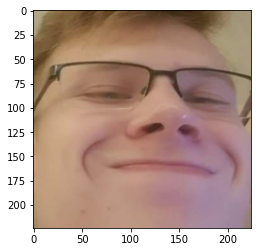

In [23]:
pyplot.imshow(Image.fromarray(X_test[0]))
pyplot.show()


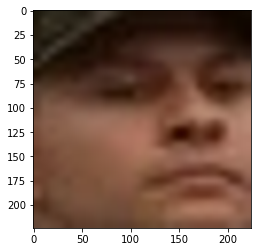

In [43]:
pyplot.imshow(Image.fromarray(X_test[27]))
pyplot.show()

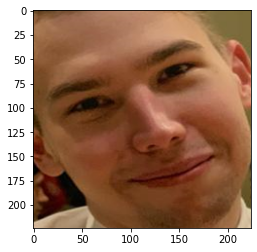

In [42]:
pyplot.imshow(Image.fromarray(X_test[51]))
pyplot.show()


# Вывод
## Ожидание 
![title](mem/5.jpg)
## Реальность
![title](mem/6.jpg)